<div class="alert alert-block alert-info">
    <center><h1> Feature Extraction </h1></center>
</div>

# Sections

- **[1. Baseline methods](#1.-Baseline-methods)**
    - [Common Spatial Pattern](#CSP---Common-Spatial-Pattern)
    - [Filter Bank CSP](#FBCSP---Filter-Bank-Common-Spatial-Pattern)
    - [Riemannian Covariance Features](#Riemannian-covariance-features)
- **[2. Deep learning methods](#2.-Deep-learning-methods)**

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

## 1. Baseline methods

### CSP - Common Spatial Pattern
[Back to top](#Sections) <br>

In [2]:
from data_loading_functions.data_loader import EEGDataset
path = '../../Datasets/BCI_IV_2a/formatted_raw/'
X_train, y_train, _, _, _, _ = EEGDataset(pilot_idx=1, data_path=path, start=2.5, end=4.5, fs=250).load_dataset()
fs = 500

#path = '../../Datasets/HGD/formatted_raw/'
#X_train, y_train, _, _, _, _ = EEGDataset(pilot_idx=1, data_path=path, fs=fs, valid_ratio=0.).load_dataset()

Properties: 288 train trials - 22 channels - 7.5s trial length
Selecting classes [0, 1, 2, 3] & balancing...
Selecting 22 channels
Selecting time-window [2.5 - 4.5]s - (2.0s)...
Output shapes:  (288, 22, 500) (288, 22, 500) (288, 22, 500)
Output classes:  [0 1 2 3]


In [3]:
from feature_extraction_functions.csp import CSP
from preprocessing_functions.preproc_functions import filtering

# CSP method requires zero-centered data. We filter the EEG input signal using mu + beta bands.
X = filtering(X_train, fs=fs, f_order=5, f_low=7, f_high=35, f_type='cheby')

csp = CSP(n_classes=4, m=2)
csp.fit(X, y_train)
X_csp = csp.transform(X)

In [4]:
X_transformed = np.array([csp.w.T @ X for X in X])
print(X_transformed.shape)

(288, 24, 500)


<IPython.core.display.Javascript object>


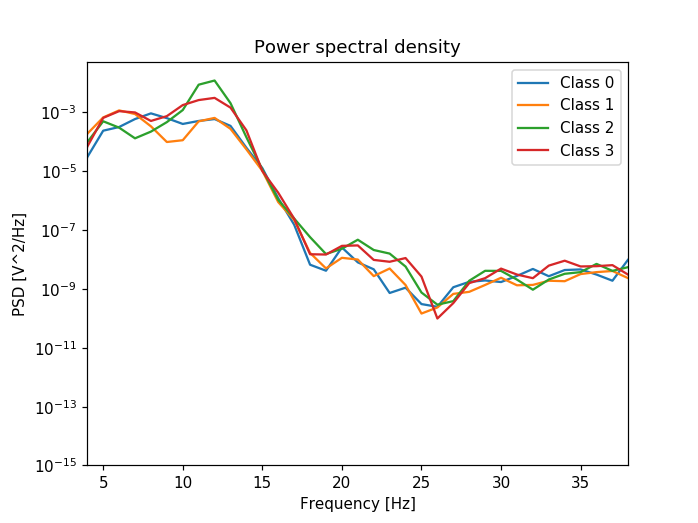

interactive(children=(IntSlider(value=0, description='channel_idx', max=21), IntSlider(value=250, description=…

In [5]:
%matplotlib notebook
from visualization_functions.signal_visualizers import psd_plot
plt.close()
fig, ax = plt.subplots()

@interact(channel_idx=(0,21), nperseg=(10,500,10))
def plot(channel_idx=0, nperseg=250):
    ax.clear()
    [ psd_plot(np.mean(X_transformed[y_train==c], axis=0)[channel_idx], 
               nperseg=nperseg, fig=fig, ax_idx=0) for c in [0,1,2,3] ]
    ax.set_xlim([4,38])
    ax.set_title('Power spectral density')
    ax.legend(['Class 0', 'Class 1', 'Class 2', 'Class 3'])

<IPython.core.display.Javascript object>


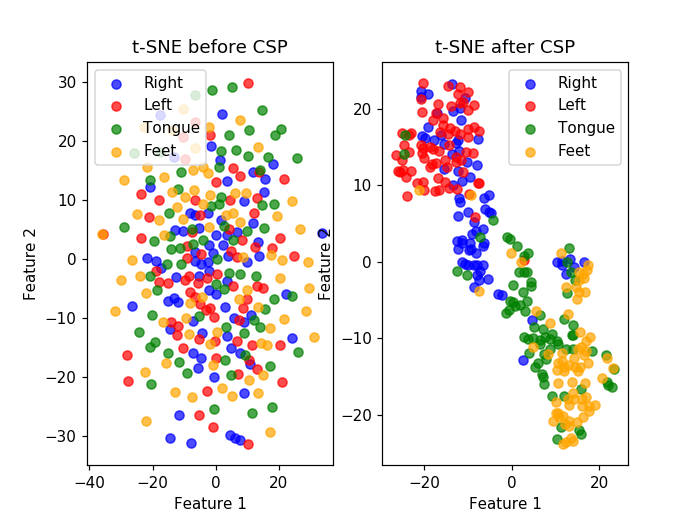

In [6]:
from visualization_functions.signal_visualizers import tsne_plot

fig, ax = plt.subplots(1,2)
tsne_plot(X, y_train, title='t-SNE before CSP', fig=fig, ax_idx=0);
tsne_plot(X_csp, y_train, title='t-SNE after CSP', fig=fig, ax_idx=1);

<IPython.core.display.Javascript object>


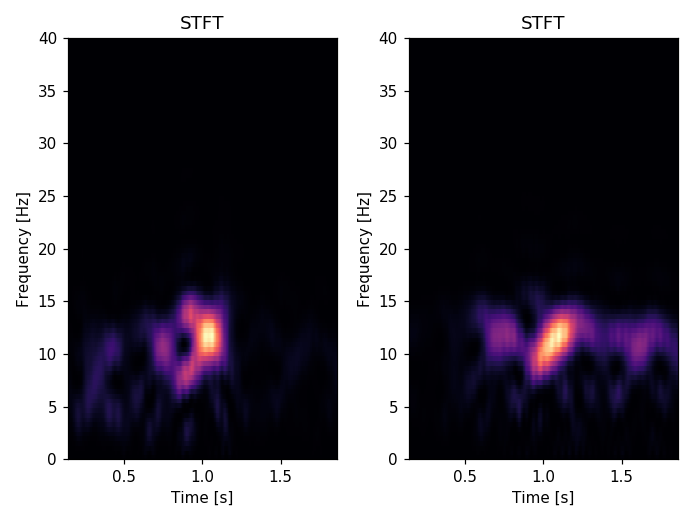

interactive(children=(IntSlider(value=0, description='channel_idx', max=21), IntSlider(value=10, description='…

In [7]:
from visualization_functions.signal_visualizers import temporal_plot, amplitude2D_plot, stft_plot, wavelets_plot

fig, ax = plt.subplots(1,2)

@interact(channel_idx=(0, X.shape[1]-1), vmax=(1,30,1))
def plot(channel_idx=0, vmax=10):
    [ axis.clear() for axis in ax.flatten() ]
    
    #temporal_plot(np.mean(X_transformed[y_train==0], axis=0)[channel_idx], fig=fig, ax_idx=0)
    #temporal_plot(np.mean(X_transformed[y_train==1], axis=0)[channel_idx], fig=fig, ax_idx=1)
    
    #amplitude2D_plot(X_transformed[y_train==0][:,channel_idx,:], y_label='Trials', fs=250, vmax=vmax, fig=fig, ax_idx=0)
    #amplitude2D_plot(np.mean(X_transformed[y_train==0], axis=0), y_label='Channels', fs=250, vmax=vmax, fig=fig, ax_idx=1)
    
    stft_plot(np.mean(X_transformed[y_train==0], axis=0)[channel_idx], f_max=40, fig=fig, ax_idx=0)
    stft_plot(np.mean(X_transformed[y_train==1], axis=0)[channel_idx], f_max=40, fig=fig, ax_idx=1)
    
    #wavelets_plot(np.mean(X_transformed[y_train==0], axis=0)[channel_idx], fig=fig, ax_idx=0)
    #wavelets_plot(np.mean(X_transformed[y_train==1], axis=0)[channel_idx], fig=fig, ax_idx=1)
    
    fig.tight_layout()

## FBCSP - Filter Bank Common Spatial Pattern
[Back to top](#Sections) <br>

In [8]:
from data_loading_functions.data_loader import EEGDataset
path = '../../Datasets/BCI_IV_2a/formatted_raw/'
X_train, y_train, _, _, _, _ = EEGDataset(pilot_idx=1, data_path=path, start=2.5, end=4.5, fs=250, load_test=False).load_dataset()

Properties: 288 train trials - 22 channels - 7.5s trial length
Selecting classes [0, 1, 2, 3] & balancing...
Selecting 22 channels
Selecting time-window [2.5 - 4.5]s - (2.0s)...
Output shapes:  (288, 22, 500) (288, 22, 500) (288, 22, 500)
Output classes:  [0 1 2 3]


In [13]:
from feature_extraction_functions.fbcsp import FBCSP
fbcsp = FBCSP(k=4, f_type='butter', f_order=2)
fbcsp.fit(X_train, y_train)
X_fbcsp = fbcsp.transform(X_train)
X_fbcsp.shape

(230, 8)

<IPython.core.display.Javascript object>


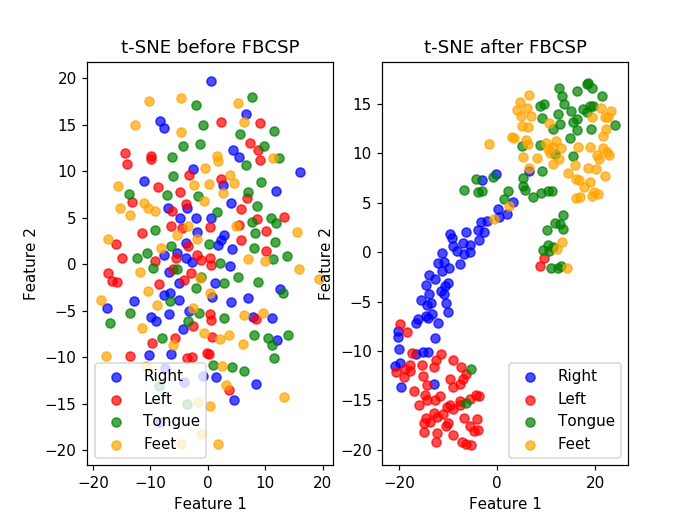

In [14]:
%matplotlib notebook
from visualization_functions.signal_visualizers import tsne_plot

fig, ax = plt.subplots(1,2)
tsne_plot(X_train, y_train, title='t-SNE before FBCSP', fig=fig, ax_idx=0);
tsne_plot(X_fbcsp, y_train, title='t-SNE after FBCSP', fig=fig, ax_idx=1);

## Riemannian covariance features
[Back to top](#Sections) <br>

In [1]:
from data_loading_functions.data_loader import EEGDataset
path = '../../Datasets/BCI_IV_2a/formatted_raw/'
X_train, y_train, _, _, _, _ = EEGDataset(pilot_idx=1, start=2.5, end=6, rereferencing=True, 
                                          data_path=path, fs=250).load_dataset()

ModuleNotFoundError: No module named 'data_loading_functions'

In [557]:
from feature_extraction_functions.riemann import Riemann
riemann = Riemann()
riemann.fit(X_train, y_train)
X_riemann = riemann.transform(X_train)
print(X_riemann.shape)

(230, 10879)


<IPython.core.display.Javascript object>


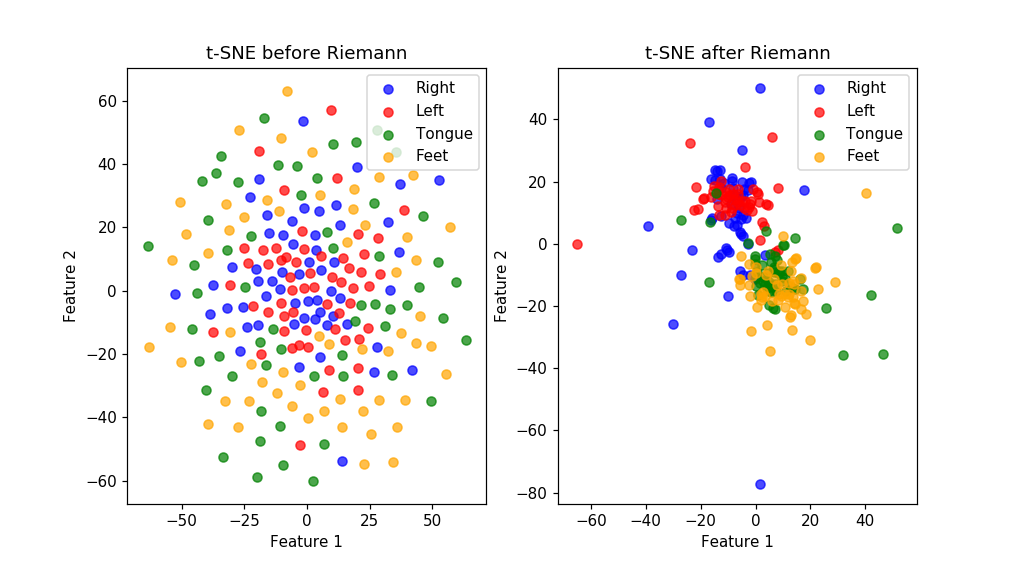

In [560]:
%matplotlib notebook
from visualization_functions.signal_visualizers import tsne_plot

fig, ax = plt.subplots(1,2)
tsne_plot(X_train, y_train, title='t-SNE before Riemann', fig=fig, ax_idx=0);
tsne_plot(X_riemann, y_train, title='t-SNE after Riemann', fig=fig, ax_idx=1);

# 2. Deep learning methods
## Shallow ConvNet
[Back to top](#Sections) <br>

**TODO:**
- Add activation visualization + corresponding STFT frequency plot
- Add t-SNE for different layers

In [13]:
from data_loading_functions.data_loader import EEGDataset
path = '../../Datasets/BCI_IV_2a/formatted_raw/'
X_train, y_train, X_valid, y_valid, X_test, y_test = EEGDataset(pilot_idx=1, start=2.5, end=6, rereferencing=True, 
                                                                 data_path=path, fs=250).load_dataset()

# Reshape in Keras format (n_trials, n_filter, n_channels, n_samples)
n_trials, n_channels, n_samples = X_train.shape
X_train = np.reshape(X_train, (n_trials, 1, n_channels, n_samples))
print('Train set shape:', X_train.shape)

n_trials, n_channels, n_samples = X_valid.shape
X_valid = np.reshape(X_valid, (n_trials, 1, n_channels, n_samples))
print('Valid set shape:', X_valid.shape)

n_trials, n_channels, n_samples = X_test.shape
X_test = np.reshape(X_test, (n_trials, 1, n_channels, n_samples))
print('Test set shape:', X_test.shape)

Properties: 288 train trials - 22 channels - 7.5s trial length
Selecting classes [0, 1, 2, 3] & balancing...
Selecting 22 channels
Selecting time-window [2.5 - 6.0]s - (3.5s)...
Re-referencing...
Output shapes:  (288, 22, 875) (288, 22, 875) (288, 22, 875)
Output classes:  [0 1 2 3]
Train set shape: (288, 1, 22, 875)
Valid set shape: (288, 1, 22, 875)
Test set shape: (288, 1, 22, 875)


In [16]:
from feature_extraction_functions.convnets import ShallowConvNet
import keras.backend as K
K.set_image_data_format("channels_first")
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam

# Load architecture
convNet = ShallowConvNet(4, n_channels, n_samples)
print(convNet.summary())
convNet.load_weights('best_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 22, 875)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 40, 22, 851)       1040      
_________________________________________________________________
conv2 (Conv2D)               (None, 40, 1, 851)        35240     
_________________________________________________________________
batch_normalization_5 (Batch (None, 40, 1, 851)        160       
_________________________________________________________________
activation_9 (Activation)    (None, 40, 1, 851)        0         
_________________________________________________________________
lambda_9 (Lambda)            (None, 40, 1, 851)        0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 40, 1, 52)         0         
__________

In [17]:
from keras.callbacks import Callback

# Source: https://github.com/comet-ml/comet-examples/blob/master/notebooks/keras.ipynb
class ActivationCallback(Callback):
    def __init__(self, model, tensor, filename, experiment):
        self.mymodel = model
        self.tensor = tensor
        self.filename = filename
        self.experiment = experiment

    def on_epoch_end(self, epoch, logs=None):
        if epoch%50==0:
            filename = self.filename % (epoch,)
            log_image(self.mymodel, self.tensor, filename,
                      self.experiment)
        
    def array_to_image(array, scale):
        from keras.preprocessing import image
        sh = array.shape
        img = image.array_to_img(array.reshape([1, sh[0]*sh[1], sh[2]]))
        x, y = img.size
        img = img.resize((x * scale, y * scale))
        return img

    def log_image(model, tensor, filename, experiment):
        output = model.predict(tensor)
        img = array_to_image(output[0], 1)
        img.save(filename)
        experiment.log_image(filename)

    def build_viz_model(model, visualize_layer):
        viz_model = Model(inputs=[model.input],
                          outputs=[model.layers[visualize_layer].output])
        return viz_model

In [20]:
%matplotlib notebook

layer_idx = 4
print(convNet.layers[layer_idx])
get_layer_outputs = K.function([convNet.layers[0].input], [convNet.layers[layer_idx].output])
layer_outputs = get_layer_outputs([X_train])[0]
output = np.squeeze(layer_outputs)

<IPython.core.display.Javascript object>


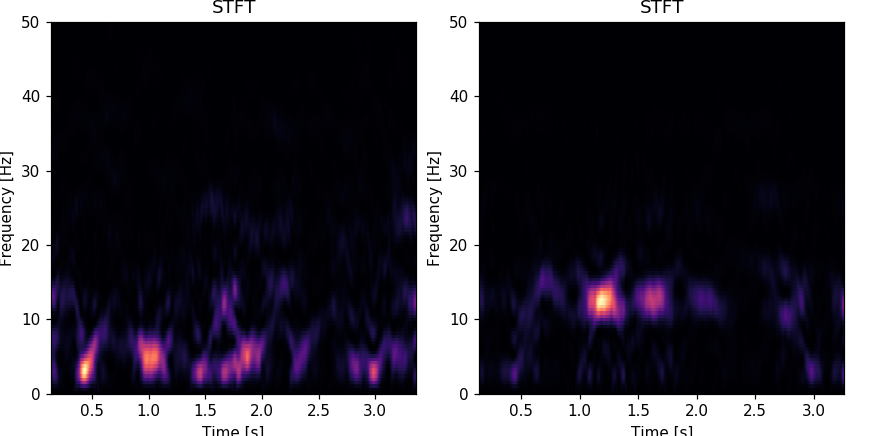

interactive(children=(IntSlider(value=0, description='depth_idx', max=39), Output()), _dom_classes=('widget-in…

In [31]:
from visualization_functions.signal_visualizers import stft_plot, amplitude2D_plot
#amplitude2D_plot(output)
fig, ax = plt.subplots(1,2, figsize=(8,4))
fig.tight_layout()

@interact(depth_idx=(0, output.shape[1]-1))
def plot(depth_idx=0):
    stft_plot(X_train[0,0,depth_idx], f_max=50, fig=fig, ax_idx=0)
    stft_plot(output[0,depth_idx], f_max=50, fig=fig, ax_idx=1)